# Deliverable 3.3 - Cascaded PID Position Control with MPC Velocity Control

This notebook demonstrates a cascaded control architecture:
- **Outer Loop (PID)**: Position tracking => generates velocity references
- **Inner Loop (MPC)**: Velocity tracking => generates control inputs

This enables the rocket to perform complex position tracking maneuvers while maintaining the safety and optimality properties of MPC.

In [1]:
%load_ext autoreload
%autoreload 2

# Get parent directory and add to sys.path
import os
import sys

parent_dir = os.path.dirname(os.getcwd())
sys.path.append(parent_dir)

# Require ipympl
%matplotlib widget

In [2]:
# MPC import
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Import controllers
from LinearMPC.MPCVelControl import MPCVelControl
from PIControl.PIControl import PIControl

# Import rocket modules
from src.rocket import Rocket
from src.vel_rocket_vis import RocketVis

rocket_obj_path = os.path.join(parent_dir, "Cartoon_rocket.obj")
rocket_params_path = os.path.join(parent_dir, "rocket.yaml")

## Design Procedure and Control Architecture

### Cascaded Control Structure

The control system uses a **two-loop cascaded architecture**:

```
Position Target => [PI Controller] => Velocity Reference => [MPC Controller] => Control Inputs => Rocket
                      (Outer Loop)                           (Inner Loop)
```



### Outer Loop: PI Position Controller

**Same tuning as provided in template**

- $K_p = 0.2$ [1/s]: Proportional gain
- $K_i = 0.0$ [1/s²]: Integral gain 
- Velocity limits: $\pm 10$ m/s


### Inner Loop: MPC Velocity Controller

Uses the MPC controllers from Deliverables 3.1 and 3.2:
- Tracks time-varying velocity references from PI controller
- Enforces all physical constraints
- Provides optimal control with prediction

**Same tuning as 3.2**:
- X/Y velocity: $Q = \text{diag}(1, 20, 50)$, $R = 1$
- Z velocity: $Q = 100$, $R = 1$
- Roll: $Q = \text{diag}(50, 200)$, $R = 1$
- Horizon: $H = 7$ seconds

### Information Flow

At each timestep:
1. **Measure** current position $p = [x, y, z]$
2. **PI Controller** computes velocity reference: $v_{ref} = K_p (p_{target} - p)$
3. **Velocity saturation**: Clip $v_{ref}$ to $\pm 10$ m/s
4. **MPC Controller** tracks $v_{ref}$: Solves OCP to find optimal $u$
5. **Apply** control $u$ to rocket
6. **Repeat**

### Stability Considerations

- **Inner loop stability**: Guaranteed by MPC terminal constraints and LQR terminal cost
- **Outer loop stability**: P controller with negative feedback is stable for positive $K_p$
- **Cascaded stability**: Fast inner loop (MPC) appears as unity gain to slower outer loop (PI)
- **Velocity saturation**: Acts as natural rate limiter, preventing aggressive position corrections

In [3]:
# Setup parameters
Ts = 0.05  # Sampling time
H = 7.0    # MPC horizon in seconds
sim_time = 40.0  # Simulation time

# Initial condition: high altitude [50, 50, 100]m
x0 = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 50, 50, 100])  # [omega, angle, v, p]

# Target position: [0, 0, 10]m (hover point for landing)
pos_target = np.array([0, 0, 10.0])

print(f"Initial position: [{x0[9]:.1f}, {x0[10]:.1f}, {x0[11]:.1f}] m")
print(f"Target position:  [{pos_target[0]:.1f}, {pos_target[1]:.1f}, {pos_target[2]:.1f}] m")
print(f"Distance to target: {np.linalg.norm(x0[9:12] - pos_target):.2f} m")
print(f"PI Controller: Kp=0.2, Ki=0.0, velocity limits: +- 10 m/s")
print(f"MPC Controller: H={H}s, same tuning as Deliverable 3.2")

Initial position: [50.0, 50.0, 100.0] m
Target position:  [0.0, 0.0, 10.0] m
Distance to target: 114.46 m
PI Controller: Kp=0.2, Ki=0.0, velocity limits: +- 10 m/s
MPC Controller: H=7.0s, same tuning as Deliverable 3.2


In [4]:
# Create rocket and controllers
rocket = Rocket(Ts=Ts, model_params_filepath=rocket_params_path)

# Outer loop: PI position controller
pos_controller = PIControl(pos_target)

# Inner loop: MPC velocity controller
mpc = MPCVelControl().new_controller(rocket, Ts, H)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************



## Closed-Loop Simulation

Simulate the cascaded control system tracking from [50, 50, 100]m to [0, 0, 10]m.

In [5]:
print("Running cascaded control simulation...")
print(f"Simulating {sim_time}s with Ts={Ts}s ({int(sim_time/Ts)} steps)")

# Run simulation with cascaded control
t_cl, x_cl, u_cl, t_ol, x_ol, u_ol, ref = rocket.simulate_control(
    mpc, sim_time, H, x0, pos_control=pos_controller, method='linear'
)

print("\nSimulation complete")
print(f"\nInitial position: [{x_cl[9,0]:.2f}, {x_cl[10,0]:.2f}, {x_cl[11,0]:.2f}] m")
print(f"Final position:   [{x_cl[9,-1]:.2f}, {x_cl[10,-1]:.2f}, {x_cl[11,-1]:.2f}] m")
print(f"Target position:  [{pos_target[0]:.2f}, {pos_target[1]:.2f}, {pos_target[2]:.2f}] m")
print(f"\nFinal position error: {np.linalg.norm(x_cl[9:12,-1] - pos_target):.4f} m")
print(f"Final velocity: [{x_cl[6,-1]:.4f}, {x_cl[7,-1]:.4f}, {x_cl[8,-1]:.4f}] m/s")
print(f"Final roll angle: {np.rad2deg(x_cl[5,-1]):.4f} deg")

Running cascaded control simulation...
Simulating 40.0s with Ts=0.05s (800 steps)
Simulating time 0.00: 
Simulating time 0.05: 
Simulating time 0.10: 
Simulating time 0.15: 
Simulating time 0.20: 
Simulating time 0.25: 
Simulating time 0.30: 
Simulating time 0.35: 
Simulating time 0.40: 
Simulating time 0.45: 
Simulating time 0.50: 
Simulating time 0.55: 
Simulating time 0.60: 
Simulating time 0.65: 
Simulating time 0.70: 
Simulating time 0.75: 
Simulating time 0.80: 
Simulating time 0.85: 
Simulating time 0.90: 
Simulating time 0.95: 
Simulating time 1.00: 
Simulating time 1.05: 
Simulating time 1.10: 
Simulating time 1.15: 
Simulating time 1.20: 
Simulating time 1.25: 
Simulating time 1.30: 
Simulating time 1.35: 
Simulating time 1.40: 
Simulating time 1.45: 
Simulating time 1.50: 
Simulating time 1.55: 
Simulating time 1.60: 
Simulating time 1.65: 
Simulating time 1.70: 
Simulating time 1.75: 
Simulating time 1.80: 
Simulating time 1.85: 
Simulating time 1.90: 
Simulating time 1.95:

## Closed-Loop Plots

Visualize the system response showing position tracking, velocity profiles, and control inputs.

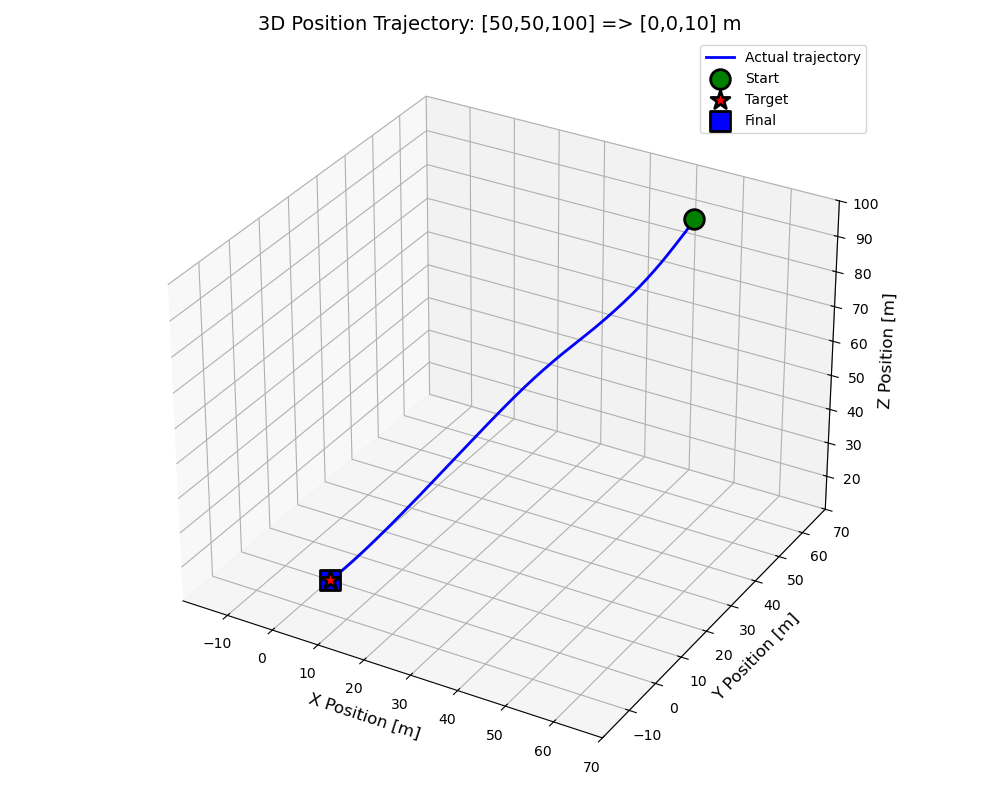

In [6]:
# 3D trajectory plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot trajectory
ax.plot(x_cl[9, :], x_cl[10, :], x_cl[11, :], 'b-', linewidth=2, label='Actual trajectory')

# Mark start and end points
ax.scatter(x_cl[9, 0], x_cl[10, 0], x_cl[11, 0], 
           c='green', s=200, marker='o', label='Start', edgecolors='black', linewidths=2)
ax.scatter(pos_target[0], pos_target[1], pos_target[2], 
           c='red', s=200, marker='*', label='Target', edgecolors='black', linewidths=2)
ax.scatter(x_cl[9, -1], x_cl[10, -1], x_cl[11, -1], 
           c='blue', s=200, marker='s', label='Final', edgecolors='black', linewidths=2)

ax.set_xlabel('X Position [m]', fontsize=12)
ax.set_ylabel('Y Position [m]', fontsize=12)
ax.set_zlabel('Z Position [m]', fontsize=12)
ax.set_title('3D Position Trajectory: [50,50,100] => [0,0,10] m', fontsize=14)
ax.legend(fontsize=10)
ax.grid(True)

# Set equal aspect ratio
max_range = np.array([x_cl[9,:].max()-x_cl[9,:].min(), 
                      x_cl[10,:].max()-x_cl[10,:].min(), 
                      x_cl[11,:].max()-x_cl[11,:].min()]).max() / 2.0
mid_x = (x_cl[9,:].max()+x_cl[9,:].min()) * 0.5
mid_y = (x_cl[10,:].max()+x_cl[10,:].min()) * 0.5
mid_z = (x_cl[11,:].max()+x_cl[11,:].min()) * 0.5
ax.set_xlim(mid_x - max_range, mid_x + max_range)
ax.set_ylim(mid_y - max_range, mid_y + max_range)
ax.set_zlim(mid_z - max_range, mid_z + max_range)

plt.tight_layout()
plt.savefig('deliverable_3_3_trajectory_3d.png', dpi=150, bbox_inches='tight')
plt.show()

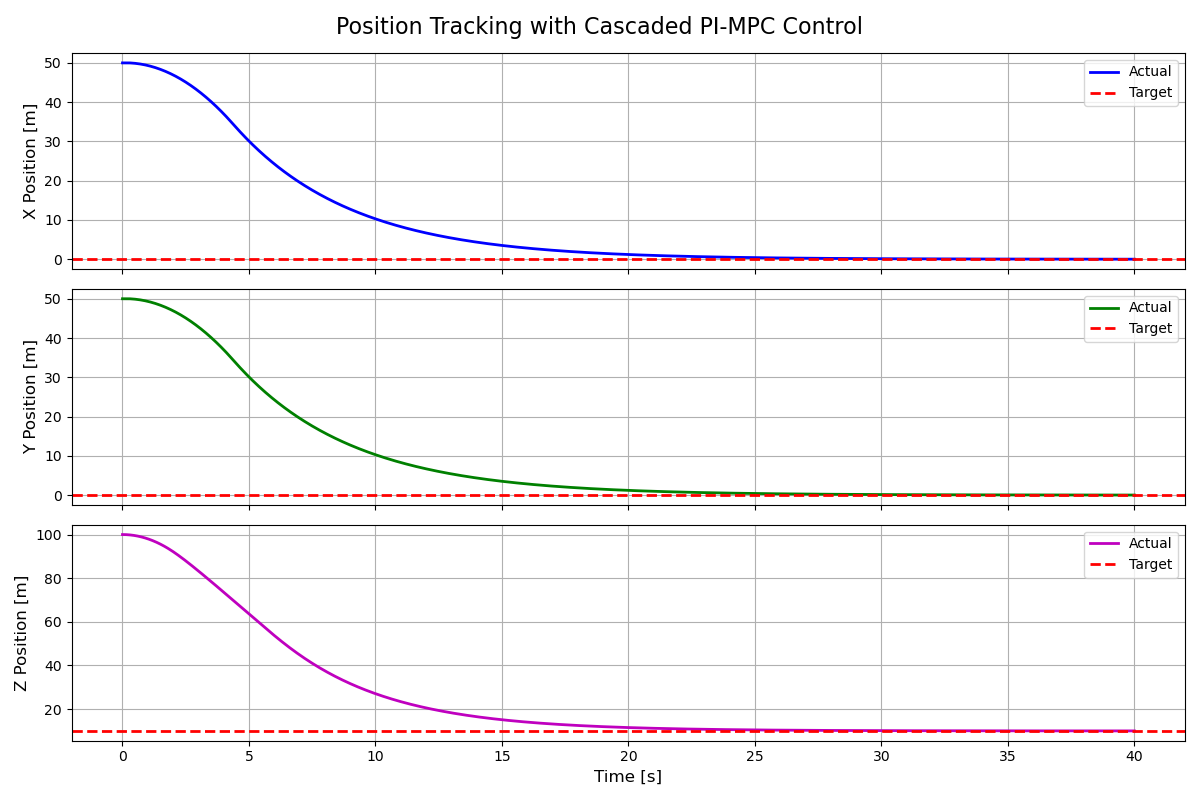


Position settling time (5% criterion): 16.00s


In [7]:
# Position tracking plots
fig, axes = plt.subplots(3, 1, figsize=(12, 8), sharex=True)
fig.suptitle('Position Tracking with Cascaded PI-MPC Control', fontsize=16)

# X position
axes[0].plot(t_cl, x_cl[9, :], 'b-', linewidth=2, label='Actual')
axes[0].axhline(y=pos_target[0], color='r', linestyle='--', linewidth=2, label='Target')
axes[0].set_ylabel('X Position [m]', fontsize=12)
axes[0].legend(loc='upper right')
axes[0].grid(True)

# Y position
axes[1].plot(t_cl, x_cl[10, :], 'g-', linewidth=2, label='Actual')
axes[1].axhline(y=pos_target[1], color='r', linestyle='--', linewidth=2, label='Target')
axes[1].set_ylabel('Y Position [m]', fontsize=12)
axes[1].legend(loc='upper right')
axes[1].grid(True)

# Z position
axes[2].plot(t_cl, x_cl[11, :], 'm-', linewidth=2, label='Actual')
axes[2].axhline(y=pos_target[2], color='r', linestyle='--', linewidth=2, label='Target')
axes[2].set_ylabel('Z Position [m]', fontsize=12)
axes[2].set_xlabel('Time [s]', fontsize=12)
axes[2].legend(loc='upper right')
axes[2].grid(True)

plt.tight_layout()
plt.savefig('deliverable_3_3_positions.png', dpi=150, bbox_inches='tight')
plt.show()

# Calculate settling time (within 5% of target)
pos_error = np.linalg.norm(x_cl[9:12, :] - pos_target.reshape(-1, 1), axis=0)
threshold = 0.05 * np.linalg.norm(x0[9:12] - pos_target)
settled_idx = np.where(pos_error < threshold)[0]
if len(settled_idx) > 0:
    settling_time = t_cl[settled_idx[0]]
    print(f"\nPosition settling time (5% criterion): {settling_time:.2f}s")

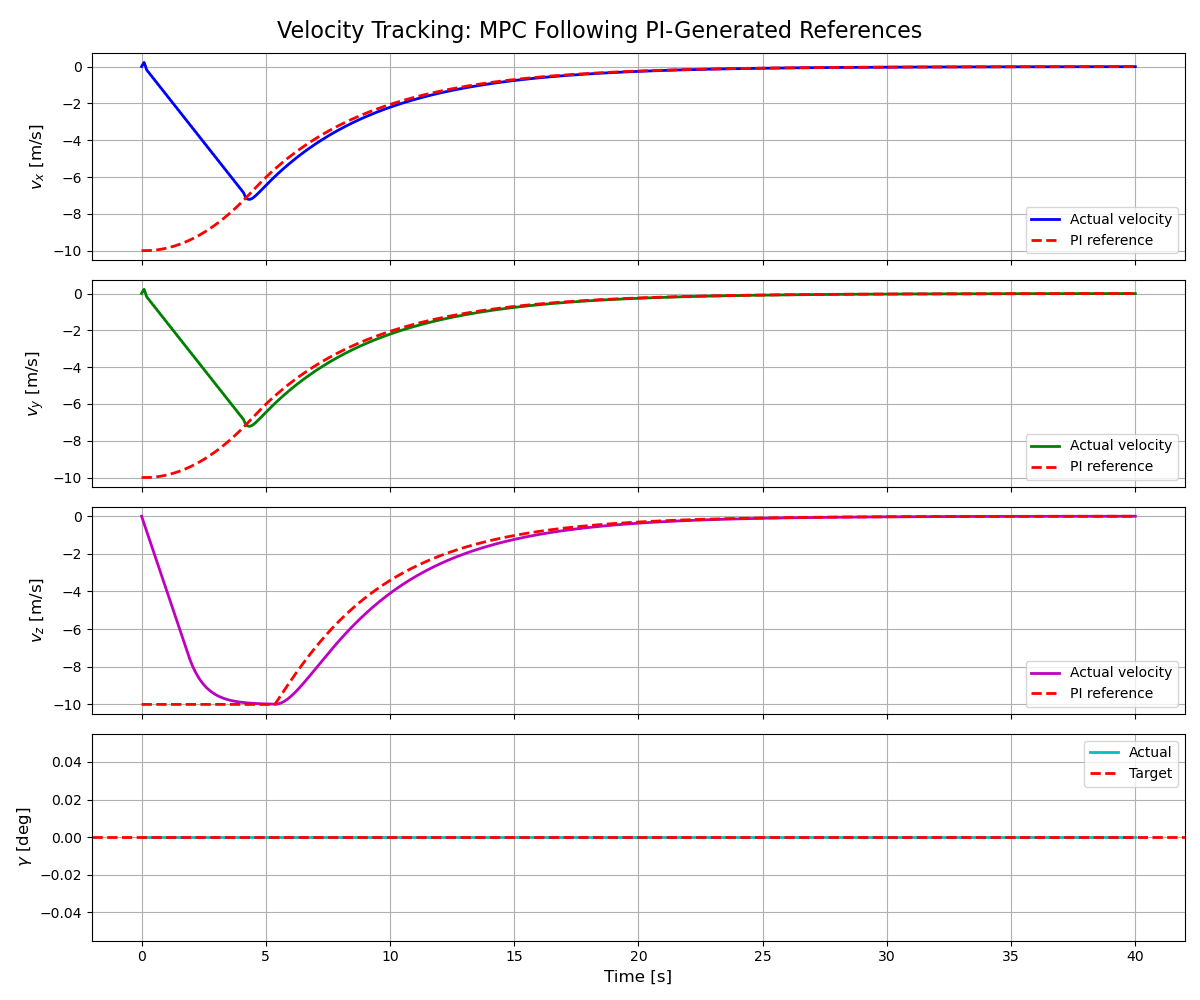

In [8]:
# Velocity profiles and references
fig, axes = plt.subplots(4, 1, figsize=(12, 10), sharex=True)
fig.suptitle('Velocity Tracking: MPC Following PI-Generated References', fontsize=16)

# X velocity
axes[0].plot(t_cl, x_cl[6, :], 'b-', linewidth=2, label='Actual velocity')
axes[0].plot(t_cl, ref[6, :], 'r--', linewidth=2, label='PI reference')
axes[0].set_ylabel(r'$v_x$ [m/s]', fontsize=12)
axes[0].legend()
axes[0].grid(True)

# Y velocity
axes[1].plot(t_cl, x_cl[7, :], 'g-', linewidth=2, label='Actual velocity')
axes[1].plot(t_cl, ref[7, :], 'r--', linewidth=2, label='PI reference')
axes[1].set_ylabel(r'$v_y$ [m/s]', fontsize=12)
axes[1].legend()
axes[1].grid(True)

# Z velocity
axes[2].plot(t_cl, x_cl[8, :], 'm-', linewidth=2, label='Actual velocity')
axes[2].plot(t_cl, ref[8, :], 'r--', linewidth=2, label='PI reference')
axes[2].set_ylabel(r'$v_z$ [m/s]', fontsize=12)
axes[2].legend()
axes[2].grid(True)

# Roll angle
axes[3].plot(t_cl, np.rad2deg(x_cl[5, :]), 'c-', linewidth=2, label='Actual')
axes[3].axhline(y=0, color='r', linestyle='--', linewidth=2, label='Target')
axes[3].set_ylabel(r'$\gamma$ [deg]', fontsize=12)
axes[3].set_xlabel('Time [s]', fontsize=12)
axes[3].legend()
axes[3].grid(True)

plt.tight_layout()
plt.savefig('deliverable_3_3_velocities.png', dpi=150, bbox_inches='tight')
plt.show()

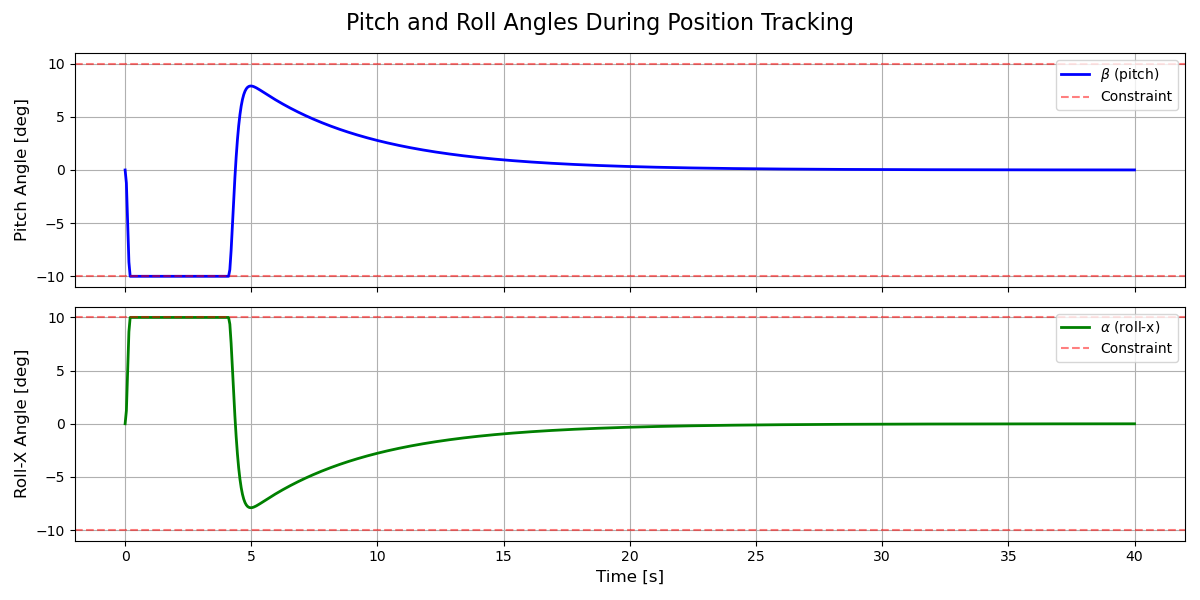

Max |alpha|: 10.00° (constraint: 10°)
Max |beta|: 10.00° (constraint: 10°)


In [9]:
# Angle evolution
fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=True)
fig.suptitle('Pitch and Roll Angles During Position Tracking', fontsize=16)

# Pitch angle (beta - about y-axis)
axes[0].plot(t_cl, np.rad2deg(x_cl[4, :]), 'b-', linewidth=2, label=r'$\beta$ (pitch)')
axes[0].axhline(y=10, color='r', linestyle='--', alpha=0.5, label='Constraint')
axes[0].axhline(y=-10, color='r', linestyle='--', alpha=0.5)
axes[0].set_ylabel('Pitch Angle [deg]', fontsize=12)
axes[0].legend()
axes[0].grid(True)

# Roll angle combined with alpha
axes[1].plot(t_cl, np.rad2deg(x_cl[3, :]), 'g-', linewidth=2, label=r'$\alpha$ (roll-x)')
axes[1].axhline(y=10, color='r', linestyle='--', alpha=0.5, label='Constraint')
axes[1].axhline(y=-10, color='r', linestyle='--', alpha=0.5)
axes[1].set_ylabel('Roll-X Angle [deg]', fontsize=12)
axes[1].set_xlabel('Time [s]', fontsize=12)
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.savefig('deliverable_3_3_angles.png', dpi=150, bbox_inches='tight')
plt.show()

# Check constraint satisfaction
max_alpha = np.max(np.abs(x_cl[3, :]))
max_beta = np.max(np.abs(x_cl[4, :]))
print(f"Max |alpha|: {np.rad2deg(max_alpha):.2f}° (constraint: 10°)")
print(f"Max |beta|: {np.rad2deg(max_beta):.2f}° (constraint: 10°)")

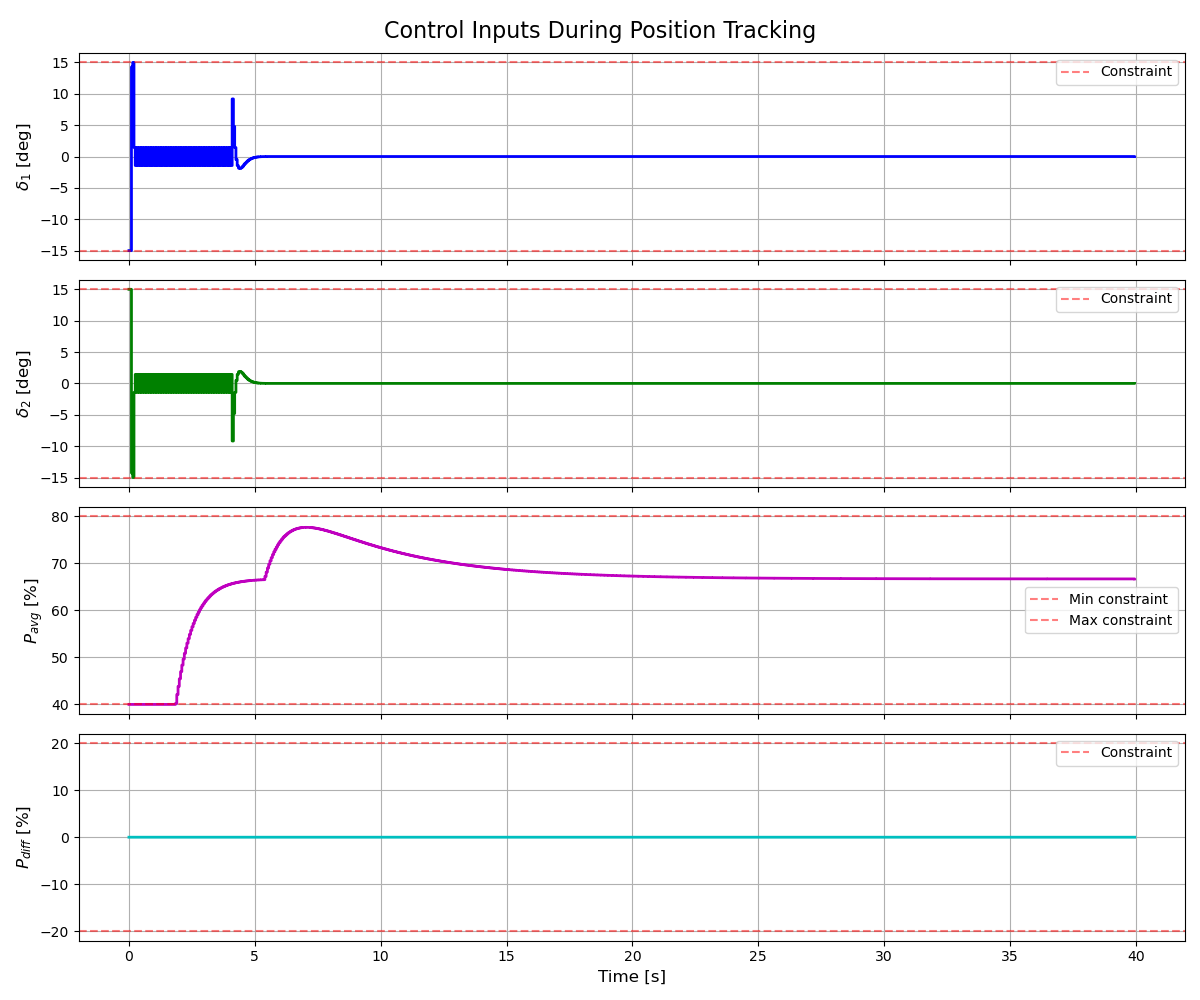


Max |delta 1|: 15.00° (constraint: 15°)
Max |delta 2|: 15.00° (constraint: 15°)
Pavg range: [40.00, 77.63]% (constraint: [40, 80]%)
Max |Pdiff|: 0.00% (constraint: 20%)


In [10]:
# Control inputs
fig, axes = plt.subplots(4, 1, figsize=(12, 10), sharex=True)
fig.suptitle('Control Inputs During Position Tracking', fontsize=16)

# Servo 1 (delta_1)
axes[0].step(t_cl[:-1], np.rad2deg(u_cl[0, :]), 'b-', linewidth=2, where='post')
axes[0].axhline(y=15, color='r', linestyle='--', alpha=0.5, label='Constraint')
axes[0].axhline(y=-15, color='r', linestyle='--', alpha=0.5)
axes[0].set_ylabel(r'$\delta_1$ [deg]', fontsize=12)
axes[0].legend()
axes[0].grid(True)

# Servo 2 (delta_2)
axes[1].step(t_cl[:-1], np.rad2deg(u_cl[1, :]), 'g-', linewidth=2, where='post')
axes[1].axhline(y=15, color='r', linestyle='--', alpha=0.5, label='Constraint')
axes[1].axhline(y=-15, color='r', linestyle='--', alpha=0.5)
axes[1].set_ylabel(r'$\delta_2$ [deg]', fontsize=12)
axes[1].legend()
axes[1].grid(True)

# Average throttle (Pavg)
axes[2].step(t_cl[:-1], u_cl[2, :], 'm-', linewidth=2, where='post')
axes[2].axhline(y=40, color='r', linestyle='--', alpha=0.5, label='Min constraint')
axes[2].axhline(y=80, color='r', linestyle='--', alpha=0.5, label='Max constraint')
axes[2].set_ylabel(r'$P_{avg}$ [%]', fontsize=12)
axes[2].legend()
axes[2].grid(True)

# Differential throttle (Pdiff)
axes[3].step(t_cl[:-1], u_cl[3, :], 'c-', linewidth=2, where='post')
axes[3].axhline(y=-20, color='r', linestyle='--', alpha=0.5, label='Constraint')
axes[3].axhline(y=20, color='r', linestyle='--', alpha=0.5)
axes[3].set_ylabel(r'$P_{diff}$ [%]', fontsize=12)
axes[3].set_xlabel('Time [s]', fontsize=12)
axes[3].legend()
axes[3].grid(True)

plt.tight_layout()
plt.savefig('deliverable_3_3_inputs.png', dpi=150, bbox_inches='tight')
plt.show()

# Check input constraint satisfaction
max_delta1 = np.max(np.abs(u_cl[0, :]))
max_delta2 = np.max(np.abs(u_cl[1, :]))
min_pavg = np.min(u_cl[2, :])
max_pavg = np.max(u_cl[2, :])
max_pdiff = np.max(np.abs(u_cl[3, :]))

print(f"\nMax |delta 1|: {np.rad2deg(max_delta1):.2f}° (constraint: 15°)")
print(f"Max |delta 2|: {np.rad2deg(max_delta2):.2f}° (constraint: 15°)")
print(f"Pavg range: [{min_pavg:.2f}, {max_pavg:.2f}]% (constraint: [40, 80]%)")
print(f"Max |Pdiff|: {max_pdiff:.2f}% (constraint: 20%)")

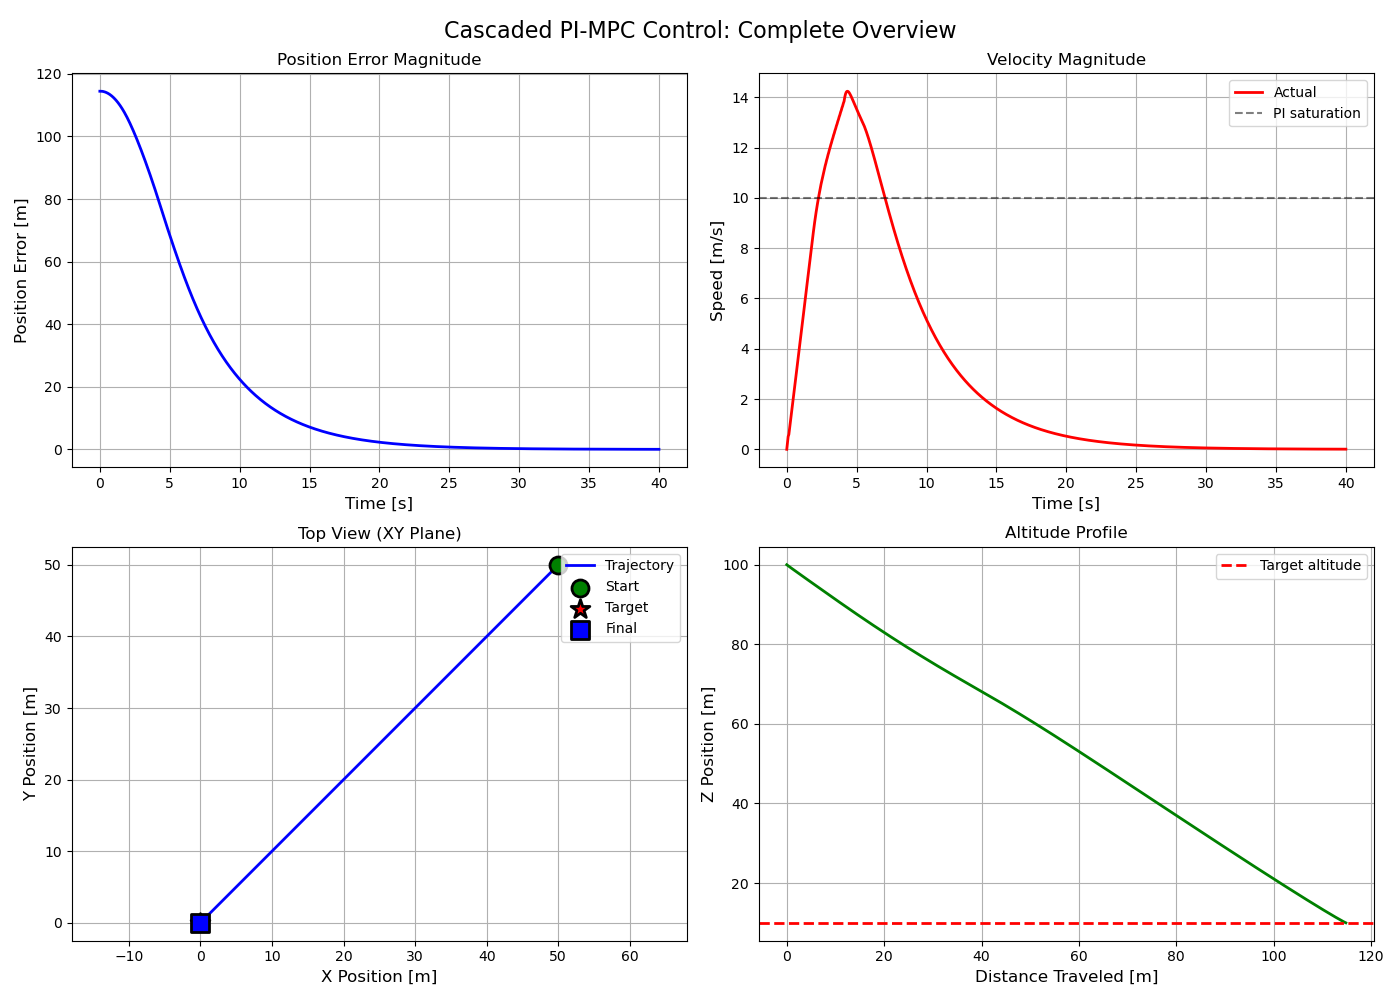

In [11]:
# Combined overview plot
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Cascaded PI-MPC Control: Complete Overview', fontsize=16)

# Position errors
ax = axes[0, 0]
pos_error_x = x_cl[9, :] - pos_target[0]
pos_error_y = x_cl[10, :] - pos_target[1]
pos_error_z = x_cl[11, :] - pos_target[2]
pos_error_norm = np.sqrt(pos_error_x**2 + pos_error_y**2 + pos_error_z**2)
ax.plot(t_cl, pos_error_norm, 'b-', linewidth=2)
ax.set_ylabel('Position Error [m]', fontsize=12)
ax.set_xlabel('Time [s]', fontsize=12)
ax.set_title('Position Error Magnitude')
ax.grid(True)

# Velocity magnitude
ax = axes[0, 1]
vel_mag = np.sqrt(x_cl[6, :]**2 + x_cl[7, :]**2 + x_cl[8, :]**2)
ax.plot(t_cl, vel_mag, 'r-', linewidth=2, label='Actual')
ax.axhline(y=10, color='k', linestyle='--', alpha=0.5, label='PI saturation')
ax.set_ylabel('Speed [m/s]', fontsize=12)
ax.set_xlabel('Time [s]', fontsize=12)
ax.set_title('Velocity Magnitude')
ax.legend()
ax.grid(True)

# XY trajectory (top view)
ax = axes[1, 0]
ax.plot(x_cl[9, :], x_cl[10, :], 'b-', linewidth=2, label='Trajectory')
ax.scatter(x_cl[9, 0], x_cl[10, 0], c='green', s=150, marker='o', 
           label='Start', edgecolors='black', linewidths=2, zorder=5)
ax.scatter(pos_target[0], pos_target[1], c='red', s=200, marker='*', 
           label='Target', edgecolors='black', linewidths=2, zorder=5)
ax.scatter(x_cl[9, -1], x_cl[10, -1], c='blue', s=150, marker='s', 
           label='Final', edgecolors='black', linewidths=2, zorder=5)
ax.set_xlabel('X Position [m]', fontsize=12)
ax.set_ylabel('Y Position [m]', fontsize=12)
ax.set_title('Top View (XY Plane)')
ax.legend()
ax.grid(True)
ax.axis('equal')

# Altitude profile
ax = axes[1, 1]
distance_traveled = np.cumsum(np.sqrt(np.diff(x_cl[9, :])**2 + 
                                       np.diff(x_cl[10, :])**2 + 
                                       np.diff(x_cl[11, :])**2))
distance_traveled = np.insert(distance_traveled, 0, 0)
ax.plot(distance_traveled, x_cl[11, :], 'g-', linewidth=2)
ax.axhline(y=pos_target[2], color='r', linestyle='--', linewidth=2, label='Target altitude')
ax.set_xlabel('Distance Traveled [m]', fontsize=12)
ax.set_ylabel('Z Position [m]', fontsize=12)
ax.set_title('Altitude Profile')
ax.legend()
ax.grid(True)

plt.tight_layout()
plt.savefig('deliverable_3_3_overview.png', dpi=150, bbox_inches='tight')
plt.show()

## 3D Animation

Visualize the complete position tracking maneuver.

In [ ]:
# Create visualization
vis = RocketVis(rocket, rocket_obj_path)
vis.anim_rate = 1.0

print("Creating animation...")
vis.animate(
    t_cl[:-1],
    x_cl[:, :-1],
    u_cl,
    Ref=ref[:, :-1],
    T_ol=t_ol[..., :-1],
    X_ol=x_ol,
    U_ol=u_ol,
)

Creating animation...


AppLayout(children=(HBox(children=(Play(value=0, description='Press play', max=799, step=2), IntSlider(value=0…

{'fig': <Figure size 640x480 with 16 Axes>,
 'axes': [<Axes: ylabel='inputs'>,
  <Axes: >,
  <Axes: >,
  <Axes: >,
  <Axes: title={'center': 'Subsystem Y'}>,
  <Axes: title={'center': 'Subsystem X'}, ylabel='$\\omega_{\\alpha\\beta\\gamma}$ (deg/s)'>,
  <Axes: title={'center': 'Subsystem Roll'}>,
  <Axes: >,
  <Axes: ylabel='$\\alpha\\beta\\gamma$ (deg)'>,
  <Axes: >,
  <Axes: ylabel='$v$ (m/s)'>,
  <Axes: >,
  <Axes: title={'center': 'Subsystem Z'}>,
  <Axes: ylabel='$\\text{pos}$ (m)'>,
  <Axes: >,
  <Axes: >],
 'plotter': <pyvista.plotting.plotter.Plotter at 0x3394098e0>,
 'scene_objects': {'rocket_actor': Actor (0x33bb482e0)
    Center:                     (50.32007, 49.9984915, 100.58848449999999)
    Pickable:                   True
    Position:                   (0.0, 0.0, 0.0)
    Scale:                      (1.0, 1.0, 1.0)
    Visible:                    True
    X Bounds                    4.936E+01, 5.128E+01
    Y Bounds                    4.879E+01, 5.121E+01
    Z Bounds

: 